In [1]:
import numpy as np
import pandas as pd
import FinanceDataReader as fdr
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname = "C:\Windows\Fonts\malgun.ttf").get_name()
rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

%matplotlib inline

In [2]:
# I didn't revise this part as definition, because asset price setting can be changed anytime

corp = ['와이솔', '코웰패션', '코엔텍', '다나와', 'KOSDAQ']
symbol = ['122990', '033290', '029960', '119860', 'KQ11']
asset_num = len(corp)-1

df = pd.DataFrame()

for sym in symbol :
    df[sym] = fdr.DataReader(sym,'2012')['Close']
    
df.columns = corp
df_daily = df.iloc[:,:]

In [3]:
def daily_to_month(start, end, df_daily):
    
    s = pd.date_range(start, end, freq = 'MS')
    e = pd.date_range(start, end, freq = 'M')

    v = []

    for i, j in zip(s, e) :
        
        date = pd.date_range(i, j)
        
        df_date_range_value = df_daily.loc[date].dropna()
        
        value_result = df_date_range_value.iloc[[0]]
        
        v.append(value_result)

    df_month = pd.concat(v)
    
    return df_month

In [4]:
def price_to_return_rate(data) :
    
    df_2 = data
    
    df_pro = (df_2 - df_2.shift(1)).iloc[1:,:]
    df_pro2 = df_2.shift(1).iloc[1:,:]
    
    df_return = df_pro / df_pro2
    
    data = df_return.iloc[:,:]
    
    return data

In [5]:
# markowitz portfolio optimization

def optimizer_markowitz(value, asset_num, data) :
    
    def objective(weights):
        return 0.5 * np.sqrt(np.dot(weights.T, np.dot(r_cov, weights)))
    
    def constraint1(weights):
        return sum(weights)-1
    
    r_cov = data.cov()
    
    w0 = [(1 / asset_num) for i in range(asset_num)]
    w0 = np.array(w0)
    objective(w0)
    
    bound = [0,1]
    bnds = [bound for i in range(asset_num)]
    con1 = {'type':'eq','fun':constraint1}
    cons = [con1]
    cons
    
    sol = minimize(objective,w0,method='SLSQP',bounds = bnds, constraints = cons)
    
    return value * sol.x.round(3)

In [6]:
# equally weighted method

def equally_weighted(x, asset_num) :

    d = x / (asset_num)
    
    return [d for i in range(len(asset_num))]

In [66]:
def main(df_daily, start, end):
    
    init = 1000000
    
    df_month = daily_to_month(start, end, df)
    data = price_to_return_rate(df_month)
    
    # we will use 2 years' data as initial covariance matrix of markowitz model
    df_return = data.iloc[23: , : -1]
    
    data = data.iloc[ : , : -1]
    df_result = df_month.iloc[24: , : ]
    
    marko_init = optimizer_markowitz(init, asset_num, data.iloc[:23, :])
    
    result = []
    
    for i in range(len(df_return)) :

        if i == 0 :

            asset_divided = []
            for j in range(asset_num) :

                value = marko_init[j] * (1 + df_return.iloc[i,j])
                asset_divided.append(value)

            asset_sum = 0
            for k in asset_divided :
                asset_sum = asset_sum + k

            result.append(asset_sum)

        else :

            asset_divided = []
            for j in range(asset_num) :

                value = optimizer_markowitz(asset_sum, asset_num, data.iloc[:23+i,:])[j] * (1 + df_return.iloc[i, j])
                asset_divided.append(value)

            asset_sum = 0
            for k in asset_divided :
                asset_sum = asset_sum + k

            result.append(asset_sum)
            
    df_result['Portfolio'] = result
    graph_portfolio = df_result['Portfolio'] / df_result['Portfolio'].iloc[0]
    graph_benchmark = df_result.iloc[:, -2:-1] / df_result.iloc[:, -2:-1].iloc[0]

    plt.style.use('seaborn')
    plt.figure(figsize=(18,6))
    plt.plot(graph_portfolio, c = 'deepskyblue', label = 'Portfolio')
    plt.plot(graph_benchmark, c = 'magenta', label = 'Benchmark')
    plt.legend(loc=0)
    
    return plt.show()

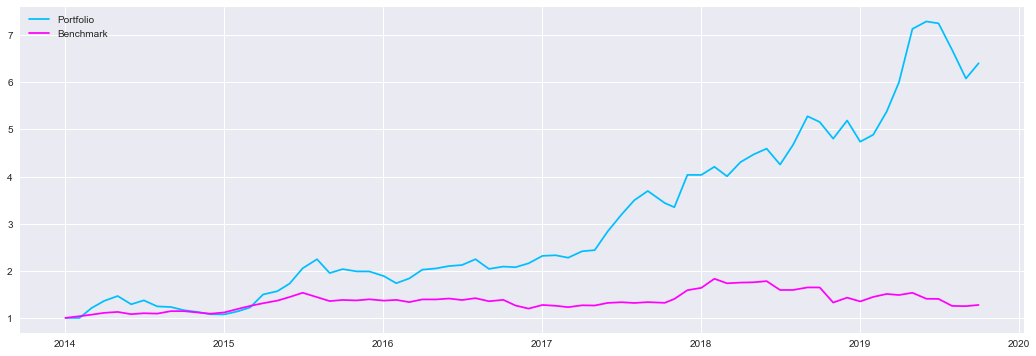

In [67]:
if __name__ == '__main__':
    main(df_daily, '2012-01-01', '2019-10-31')

In [ ]:
df_graph = df_result.iloc[:,4:]/df_result.iloc[:,4:].iloc[0]
df_graph.plot(figsize=(18,6))

In [11]:
result_marko = []
init = 1000000
marko_init = engine(init, data.iloc[:23,:])

for i in range(len(df_return)) :
    
    if i == 0 :
        
        asset_divided = []
        for j in range(asset_num) :
            
            value = marko_init[j] * (1 + df_return.iloc[i,j])
            asset_divided.append(value)
            
        asset_sum = 0
        for k in asset_divided :
            asset_sum = asset_sum + k

        result_marko.append(asset_sum)
    
    else :
        
        asset_divided = []
        for j in range(asset_num) :
            
            value = optimizer_markowitz(asset_sum, data.iloc[:23+i,:])[j] * (1 + df_return.iloc[i,j])
            asset_divided.append(value)
        
        asset_sum = 0
        for k in asset_divided :
            asset_sum = asset_sum + k

        result_marko.append(asset_sum)

In [12]:
result_equally = []

initial = [init/4 for i in range(asset_num)]

for i in range(len(df_return)) :
    
    if i == 0 :
        
        asset_divided = []
        for j in range(asset_num) :
            
            value = initial[j] * (1 + df_return.iloc[i,j])
            asset_divided.append(value)
            
        asset_sum = 0
        for k in asset_divided :
            asset_sum = asset_sum + k

        result_equally.append(asset_sum)
    
    else :
        
        asset_divided = []
        for j in range(asset_num) :
            
            value = equally_weighted(asset_sum)[j] * (1 + df_return.iloc[i,j])
            asset_divided.append(value)
        
        asset_sum = 0
        for k in asset_divided :
            asset_sum = asset_sum + k

        result_equally.append(asset_sum)

In [13]:
df_result = df.iloc[1:,:]
df_result['Portfolio_equally'] = result_equally
df_result['Portfolio_markowitz'] = result_marko

c:\users\gus26\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\gus26\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


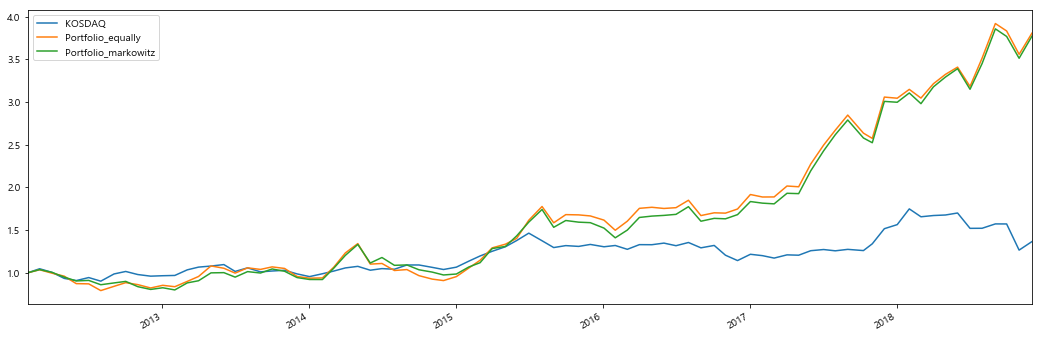

In [14]:
df_graph = df_result.iloc[:,4:]/df_result.iloc[:,4:].iloc[0]
df_graph.plot(figsize=(18,6))

In [15]:
df_result

,와이솔,코웰패션,코엔텍,다나와,KOSDAQ,Portfolio_equally,Portfolio_markowitz
2012-02-01,8983.0,1275.0,3415.0,3831.0,519.25,1.012976e+06,1.045790e+06
2012-03-02,9189.0,1265.0,3630.0,4079.0,543.97,1.049134e+06,1.085352e+06
2012-04-02,8221.0,1300.0,3075.0,4383.0,521.80,1.008208e+06,1.051055e+06
2012-05-02,8192.0,1235.0,3070.0,4024.0,485.54,9.736611e+05,9.932339e+05
2012-06-01,7516.0,1420.0,2420.0,3137.0,472.13,8.848447e+05,9.464410e+05
2012-07-02,7428.0,1440.0,2340.0,3193.0,490.43,8.820065e+05,9.528970e+05
2012-08-01,6166.0,1335.0,2080.0,3167.0,468.53,8.021699e+05,8.999683e+05
2012-09-03,6870.0,1335.0,2300.0,3269.0,512.45,8.527368e+05,9.219510e+05
2012-10-02,7898.0,1365.0,2325.0,3340.0,527.56,8.963750e+05,9.408162e+05
2012-11-01,8280.0,1175.0,2125.0,3583.0,508.83,8.730480e+05,8.764007e+05
